In [1]:
%gui wx
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from mayavi import mlab
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
import operator
import pickle

/home/raid3/huntenburg/workspace/try_openblas/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def make_cluster_cmap(c):
    cmap = np.asarray(sns.color_palette('cubehelix', c-1))
    np.random.shuffle(cmap)
    cmap = np.concatenate((np.array([[0.4,0.4,0.4]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [4]:
def make_cont_cmap(c):
    cmap = np.asarray(sns.cubehelix_palette(c-1, start=.5, rot=-.75, reverse=True))
    #cmap = np.asarray(sns.color_palette('Reds_r', c-1))
    cmap = np.concatenate((np.array([[0.4,0.4,0.4]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [5]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

### load data

In [65]:
hemi='rh'
embed=10
k=15
smooth='smooth_3'
masktype='025_5'

mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d.vtk'%hemi
mask_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/%s_mask.1D.roi'%hemi
#embed_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/%s/mask_%s/%s_embed_%s.npy'%(smooth, masktype, hemi, str(embed))
#embed_res_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/%s/mask_%s/%s_embed_%s_dict.pkl'%(smooth, masktype, hemi, str(embed))
kmeans_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/%s/mask_%s/%s_embed_%s_kmeans_%s.npy'%(smooth, masktype, hemi, str(embed), str(k))
subclust_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/%s/mask_%s/%s_embed_%s_kmeans_%s_subclust.npy'%(smooth, masktype, hemi, str(embed), str(k))
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/avg_%s_profiles.npy'%(hemi)

#var_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_var.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#t_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_avg_t.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#p_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_avg_p.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#fig_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_violins.svg'%(str(n_components_kmeans),smooth, sub, hemi)

In [66]:
v,f,d = read_vtk(mesh_file)
x=v[:,0]
y=v[:,1]
z=v[:,2]
triangles=f


mask = np.loadtxt(mask_file)[:,0]
clust=np.load(kmeans_file)
subclust=np.load(subclust_file)
t1=np.load(t1_file)

### Get T1 values in all clusters

In [67]:
# make a list of dictionaries for each cluster k0, k1, ...(0=mask to max kmeans) 
# and subcluster s0_0, s0_1, s0_2, ..(0 to max subcluster)
t1_clust={}
t1_subclust={}
for c in range(int(clust.max()+1)):
    t1_clust['k'+str(c)]=[]
    for s in range(int(subclust[:,c].max())):
        t1_subclust['k'+str(c)+'_'+str(s+1)]=[]

# write all t1 values in one cluster into the list of its dictionary
for i in range(len(t1)):
    kn=int(clust[i])
    sub=int(subclust[:,kn][i])
    t1_clust['k'+str(kn)].append(t1[i])
    t1_subclust['k'+str(kn)+'_'+str(sub)].append(t1[i])

In [68]:
# make other dictionaries with 3 to 7 intracortical profiles and averages, thresholded  1400 to 2500 mean
t1_clust_37={}
t1_clust_37_avg={}
t1_subclust_37={}
t1_subclust_37_avg={}

for c in range(int(clust.max()+1)):
    t1_clust_37['k'+str(c)]=[pro[3:8] for pro in t1_clust['k'+str(c)]
                             if np.mean(pro[3:8]) < 2500
                             and np.mean(pro[3:8]) > 1400]
    t1_clust_37_avg['k'+str(c)]=[np.mean(pro_37) for pro_37 in t1_clust_37['k'+str(c)]]
    
    for s in range(int(subclust[:,c].max())):
        t1_subclust_37['k'+str(c)+'_'+str(s+1)]=[pro[3:8] for pro in t1_subclust['k'+str(c)+'_'+str(s+1)]
                                                if np.mean(pro[3:8]) < 2500
                                                and np.mean(pro[3:8]) > 1400]
        t1_subclust_37_avg['k'+str(c)+'_'+str(s+1)]=[np.mean(pro_37) for pro_37 in t1_subclust_37['k'+str(c)+'_'+str(s+1)]]

### Plot resorted clusters and T1 distributions

In [87]:
pal, pal_255 = make_cluster_cmap(k+1)

In [88]:
Tclust = t1_clust_37_avg.copy()
Tsubclust = t1_subclust_37_avg.copy()

In [89]:
# remove very small subcluster and mask subcluster
len_thr = 200

subkeys = Tsubclust.keys()
for sk in subkeys:
    if sk[1]=='0':
        Tsubclust.pop(sk);
    else:
        if len(Tsubclust[sk]) < len_thr:
            Tsubclust.pop(sk);

In [90]:
plot_list=[]
cluster_list=[]
pal_sub = []
# here we neglect the masked out k=0 cluster
for c in range(int(clust.max())):
    for s in range(int(subclust[:,c+1].max())):
        # check if the item is still in the dict after removing small and mask subclusts
        if 'k'+str(c+1)+'_'+str(s+1) in Tsubclust.keys():
            plot_list+=Tsubclust['k'+str(c+1)+'_'+str(s+1)]
            cluster_list+=len(Tsubclust['k'+str(c+1)+'_'+str(s+1)])*['k'+str(c+1)+'_'+str(s+1)]
            pal_sub.append(pal[c+1])
    
plot_df=pd.DataFrame(columns=['t1', 'cluster'])
plot_df['t1']=plot_list
plot_df['cluster']=cluster_list

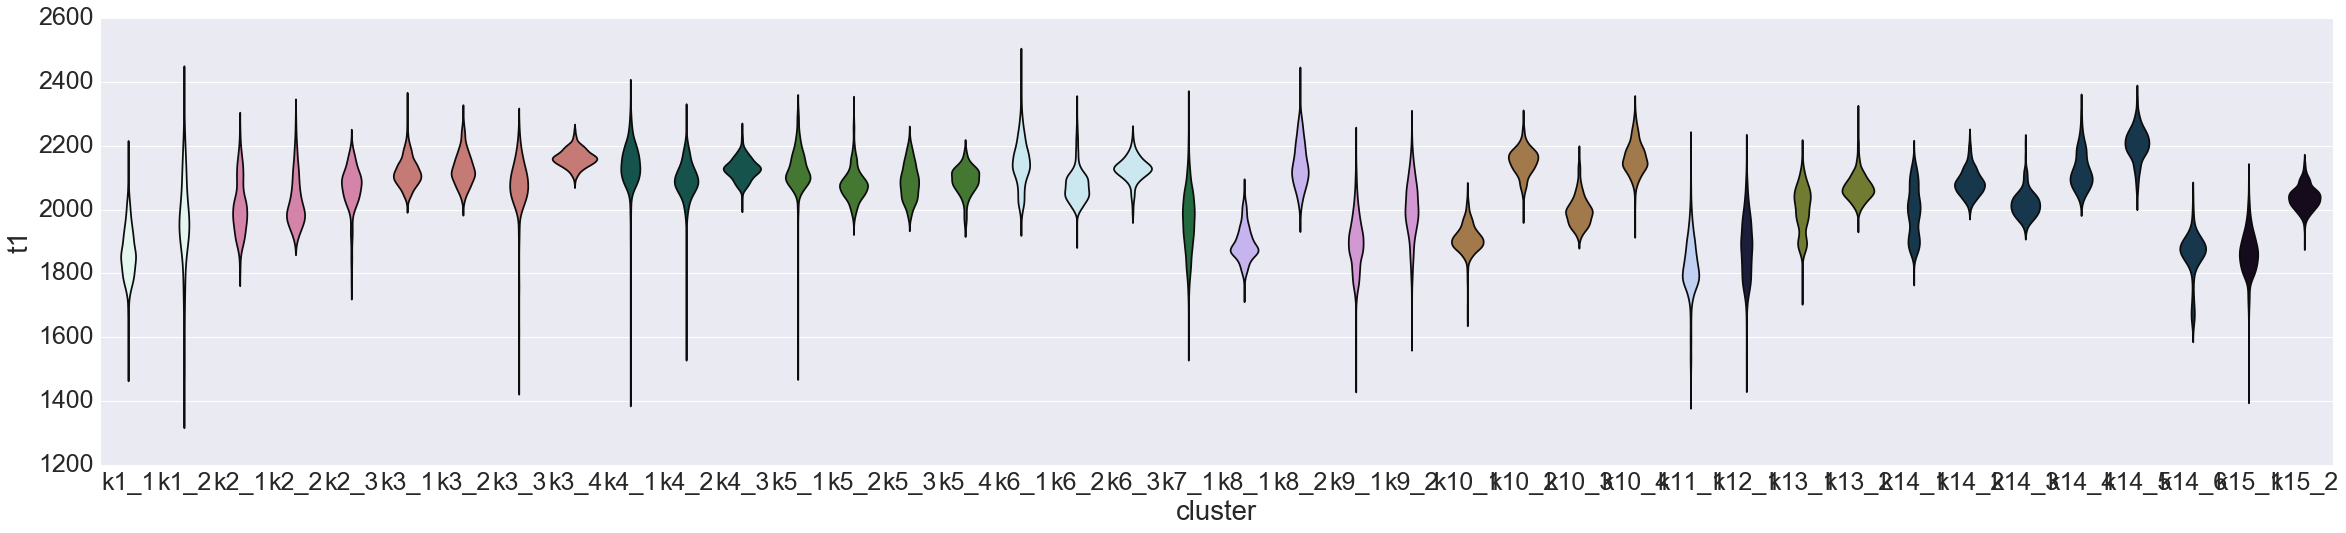

In [91]:
sns.set_context('notebook', font_scale=2.5)
fig = plt.figure(figsize=(40,8))
sns.violinplot(x='cluster', y='t1',data=plot_df, palette=pal_sub, inner=None, saturation=1)
#sns.violinplot(x='cluster', y='t1',data=plot_df, palette=pal_cont[1:], inner='box', saturation=1)
#sns.axlabel('','t1_avg', fontsize=22)
#fig.savefig('/scr/ilz3/myelinconnect/pics/subclustering/mask_%s/rh_subcluster_k_%s_thr_%s.png'%(masktype,k,len_thr))

### sort by means

In [92]:
means = {}
# The small and mask subclusters have already been removed above
subkeys = Tsubclust.keys()
for sk in range(len(subkeys)):
    means[subkeys[sk]]= np.mean(Tsubclust[subkeys[sk]])
    
sorted_means = sorted(means.items(), key=operator.itemgetter(1))
#sorted_pal = [pal_sub[int(sorted_means[p][0][1:])] for p in range(len(sorted_means))] 

sorted_clust = np.zeros_like(clust)
sorted_pal = []
for p in range(len(sorted_means)):
    kp = int(sorted_means[p][0].split('_')[0][1:])
    sp = int(sorted_means[p][0].split('_')[1])
    sorted_clust[np.where(subclust[:,kp]==sp)]=(p+1)
    
    sorted_pal.append(pal[kp])
    #sorted_pal.append(pal_contsort[kp])

sorted_plot_list=[]
sorted_cluster_list=[]
for m in range(len(sorted_means)):
    sorted_plot_list+=Tsubclust[sorted_means[m][0]]
    sorted_cluster_list+=len(Tsubclust[sorted_means[m][0]])*[sorted_means[m][0]]
    
sorted_plot_df=pd.DataFrame(columns=['t1', 'cluster'])
sorted_plot_df['t1']=sorted_plot_list
sorted_plot_df['cluster']=sorted_cluster_list


pal_cont, pal_cont_255 = make_cont_cmap(len(sorted_means)+1)

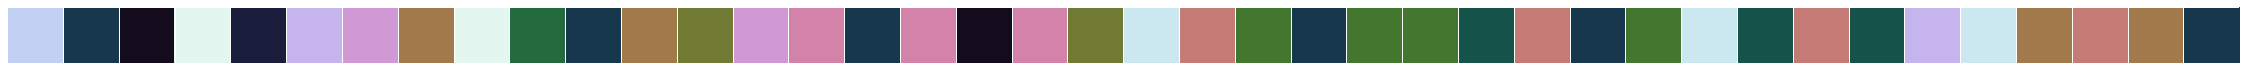

In [93]:
fig = plt.figure()
sns.palplot(sorted_pal)
#fig.savefig('/scr/ilz3/myelinconnect/pics/subclustering/mask_%s/rh_subcluster_k_%s_thr_%s_sorted_cbar.png'%(masktype,k,len_thr))

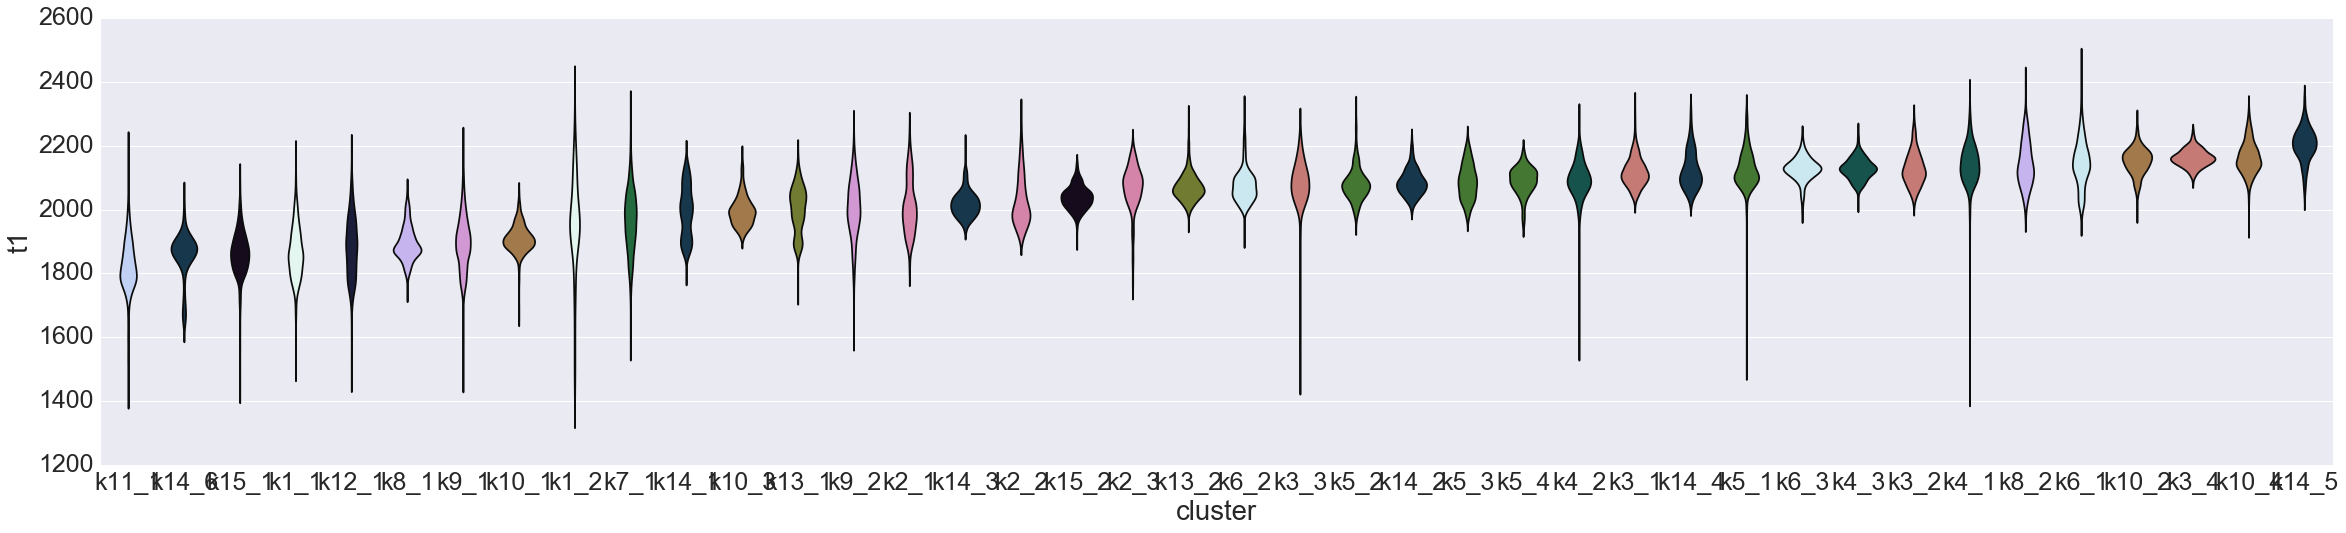

In [94]:
sns.set_context('notebook', font_scale=2.5)
fig = plt.figure(figsize=(40,8))
#sns.violinplot(x='cluster', y='t1',data=sorted_plot_df, palette=pal_cont[1:], inner='box', saturation=1)
sns.violinplot(x='cluster', y='t1',data=sorted_plot_df, palette=sorted_pal, inner=None, saturation=1)
#sns.axlabel('','t1_avg', fontsize=22)
#fig.savefig('/scr/ilz3/myelinconnect/pics/subclustering/mask_%s/rh_subcluster_k_%s_thr_%s_sorted.png'%(masktype,k,len_thr))

In [34]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=clust, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_255
mlab.draw()
mlab.show()

In [302]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=sorted_clust, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_cont_255
mlab.draw()
mlab.show()

### plot subcluster on surface

In [8]:
main=3
#network = np.zeros_like(clust)
#network[np.where(clust==p)]=1
network=subclust[:,main].copy()
for i in np.unique(network):
    if np.where(network==i)[0].shape[0] < len_thr:
        network[np.where(network==i)]=0

pal_net, pal_net_255 = make_cluster_cmap(int(np.unique(network).shape[0]))

In [23]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=network, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_net_255
mlab.draw()
mlab.show()

### Jensen-Shannon divergence

The Jensen-Shannon divergence measures the similarity of two probability functions, roughly the amount of information lost when one function is approximated by the other. It is derived from the Kullback-Leibler divergence however as compared to that has the advantage of being symmetric and always finite.
adapted from stackoverflow http://stats.stackexchange.com/questions/29578/jensen-shannon-divergence-calculation-for-3-prob-distributions-is-this-ok & scipy open PR https://github.com/scipy/scipy/pull/3213

In [69]:
def jensenshannon(x,y):
    import warnings
    warnings.filterwarnings("ignore", category = RuntimeWarning)
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    x=x/x.sum()
    y=y/y.sum()
    m = (x + y)/2.
    m = np.where(m,m,1.)
    d1 = x*np.log2(2*x/m)
    d2 = y*np.log2(2*y/m)
    d1[np.isnan(d1)] = 0
    d2[np.isnan(d2)] = 0
    d = 0.5*np.sum(d1+d2)    
    return d

In [70]:
Tsubclust = t1_subclust_37_avg.copy()

In [71]:
p34, x34 = np.histogram(Tsubclust['k3_4'], bins=100, density=True)
p35, x35 = np.histogram(Tsubclust['k3_5'], bins=100, density=True)
p33, x33 = np.histogram(Tsubclust['k3_3'], bins=100, density=True)
x34 = x34[:-1] + (x34[1] - x34[0])/2
x35 = x35[:-1] + (x35[1] - x35[0])/2
x33 = x33[:-1] + (x33[1] - x33[0])/2

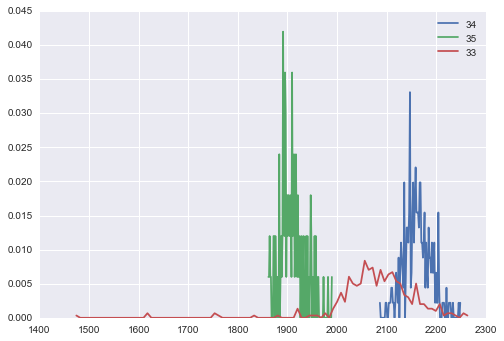

In [72]:
sns.set_context('notebook')
plt.plot(x34,p34, label='34')
plt.plot(x35,p35, label='35')
plt.plot(x33,p33, label='33')
plt.legend()

In [73]:
full=np.zeros((2500))
full_34=full.copy()
full_34[np.asarray(np.round(x34), dtype='int64')]=p34
full_35=full.copy()
full_35[np.asarray(np.round(x35), dtype='int64')]=p35
full_33=full.copy()
full_33[np.asarray(np.round(x33), dtype='int64')]=p33

In [74]:
print np.sqrt(jensenshannon(full_34[1400:2500], full_34[1400:2500]))
print np.sqrt(jensenshannon(full_34[1400:2500], full_33[1400:2500]))
print np.sqrt(jensenshannon(full_35[1400:2500], full_33[1400:2500]))
print np.sqrt(jensenshannon(full_34[1400:2500], full_35[1400:2500]))

1.0
1.3786374436
1.40798028946
1.41421356237


In [75]:
p41, x41 = np.histogram(Tsubclust['k4_1'], bins=100, density=True)
p42, x42 = np.histogram(Tsubclust['k4_2'], bins=100, density=True)
p43, x43 = np.histogram(Tsubclust['k4_3'], bins=100, density=True)
p44, x44 = np.histogram(Tsubclust['k4_4'], bins=100, density=True)
x41 = x41[:-1] + (x41[1] - x41[0])/2
x42 = x42[:-1] + (x42[1] - x42[0])/2
x43 = x43[:-1] + (x43[1] - x43[0])/2
x44 = x44[:-1] + (x44[1] - x44[0])/2

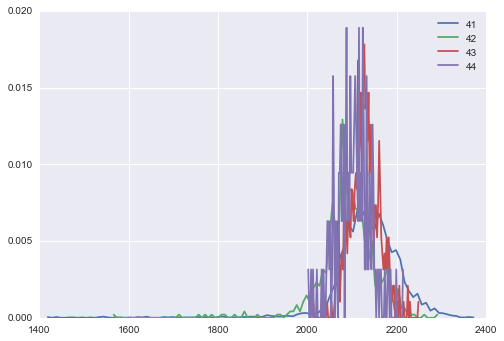

In [76]:
plt.plot(x41,p41, label='41')
plt.plot(x42,p42, label='42')
plt.plot(x43,p43, label='43')
plt.plot(x44,p44, label='44')
plt.legend()

In [77]:
full=np.zeros((2500))
full_41=full.copy()
full_41[np.asarray(np.round(x41), dtype='int64')]=p41
full_42=full.copy()
full_42[np.asarray(np.round(x42), dtype='int64')]=p42
full_43=full.copy()
full_43[np.asarray(np.round(x43), dtype='int64')]=p43
full_44=full.copy()
full_44[np.asarray(np.round(x44), dtype='int64')]=p44

In [78]:
print np.sqrt(jensenshannon(full_41[2000:2250], full_42[2000:2250]))
print np.sqrt(jensenshannon(full_41[1400:2500], full_43[1400:2500]))
print np.sqrt(jensenshannon(full_41[1400:2500], full_44[1400:2500]))

1.38608337374
1.39043365353
1.38400482947
